In [2]:
import numpy as np
import matplotlib.pyplot as plt
import functions 
import ot

import pandas as pd 
import seaborn as sns
from sklearn.neighbors import NearestNeighbors 

from matplotlib import cm
from matplotlib import colors


plt.rcParams.update({'font.size': 14})

cmap = cm.get_cmap('tab20c')
y1_color = cmap(1/20) #blue
y2_color = cmap(6/20) #orange
y3_color = cmap(9/20) #green
y4_color = cmap(14/20) #purple

/var/folders/wb/j_66l1b92d580qv2dsc3kpmr0000gp/T/ipykernel_10185/283750305.py:16: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = cm.get_cmap('tab20c')


# 1st METHOD NON-ADAPTIVE TO THE COVARIATES X  
### i.e. treating scores independently of X 

The next cell defines functions to compare MK quantiles and regions of prescribed shapes: ellipsoid / hyperrectangle. 

In [3]:

from matplotlib.patches import Rectangle 

def get_rectangle(scores,alpha): 
    marginal_alpha = np.sqrt(alpha) 
    center_outward_m = (1 - marginal_alpha)/2  
    axis0 = np.quantile(scores.T[0],[1-center_outward_m,center_outward_m]) 
    axis1 = np.quantile(scores.T[1],[1-center_outward_m,center_outward_m]) 
    hyperrectangle = Rectangle((axis0[0],axis1[0]), axis0[1]-axis0[0], axis1[1]-axis1[0],
                               fill=False,color=y2_color,linewidth=3,linestyle='--') 
    return(hyperrectangle)

def get_vol_rectangle(scores,alpha):
    marginal_alpha = np.sqrt(alpha)
    center_outward_m = (1 - marginal_alpha)/2 
    prod = 1 
    for j in range(scores.shape[1]):
        borders = np.quantile(scores.T[j],[1-center_outward_m,center_outward_m])
        #print(borders)
        prod = prod * (borders[0]-borders[1])
    return(prod)


def matrix_to_param(mat):
    """
    Function taken from https://github.com/M-Soundouss/EllipsoidalConformalMTR/tree/main. 
    Calculates an ellipse's parameters to draw it as in https://cookierobotics.com/007/
    :param mat: Covariance matrix
    :return: Ellipse's parameters
    """
    lambda1 = (mat[0, 0] + mat[1, 1]) / 2 + np.sqrt(
        ((mat[0, 0] - mat[1, 1]) / 2) ** 2 + mat[0, 1] ** 2
    )
    lambda2 = (mat[0, 0] + mat[1, 1]) / 2 - np.sqrt(
        ((mat[0, 0] - mat[1, 1]) / 2) ** 2 + mat[0, 1] ** 2
    )

    if mat[0, 1] == 0 and mat[0, 0] >= mat[1, 1]:
        theta = 0
    elif mat[0, 1] == 0 and mat[0, 0] < mat[1, 1]:
        theta = np.pi / 2
    else:
        theta = np.arctan2(lambda1 - mat[0, 0], mat[0, 1])

    return np.sqrt(lambda1), np.sqrt(lambda2), theta

from math import degrees
from matplotlib.patches import Ellipse

def get_ellipse(scores,alpha):
    cov = np.cov(scores.T)
    cov_1 = np.linalg.inv(cov)
    MahalanobisNCM = -np.ones(len(scores)) # Mahalanobis Non-Conformity Measure
    for k in range(len(scores)):
        MahalanobisNCM[k] = scores[k].T @ cov_1 @ scores[k]
    OrderStatistics = np.argsort(MahalanobisNCM)
    q = alpha *(1+1/len(scores))
    indexTreshold = OrderStatistics[(int(q*len(scores))+1)]
    alpha_s = MahalanobisNCM[indexTreshold]
    #print(np.mean(MahalanobisNCM <= alpha_s))
    width, height, theta = matrix_to_param(cov * alpha_s )
    ellipsis = Ellipse(
            xy=(0,0),
            width = 2 * width,
            height = 2 * height,
            angle = degrees(theta),
            linewidth=3,
            color="lightpink",
            fill=False
        )
    return(ellipsis)

from scipy.special import gamma

def get_vol_ellipse(scores,alpha):
    cov = np.cov(scores.T)
    cov_1 = np.linalg.inv(cov)
    MahalanobisNCM = -np.ones(len(scores)) # Mahalanobis Non-Conformity Measure
    for k in range(len(scores)):
        MahalanobisNCM[k] = scores[k].T @ cov_1 @ scores[k]
    OrderStatistics = np.argsort(MahalanobisNCM)
    q = alpha *(1+1/len(scores))
    indexTreshold = OrderStatistics[(int(q*len(scores))+1)]
    alpha_s = MahalanobisNCM[indexTreshold]
    d = scores.shape[1] # The number of dimensions
    volume_unit_ball = np.pi**(d/2) / gamma(d/2 + 1)
    return( np.linalg.det( cov*alpha_s )**(1/2) * volume_unit_ball )


For our example on simulated data, we consider the following mixture of Gaussians as the distribution of the noise around the prediction $\hat{f}$. 

(-1.2696864288715628,
 1.5138525709611075,
 -0.8706838680272104,
 0.8624584972124858)

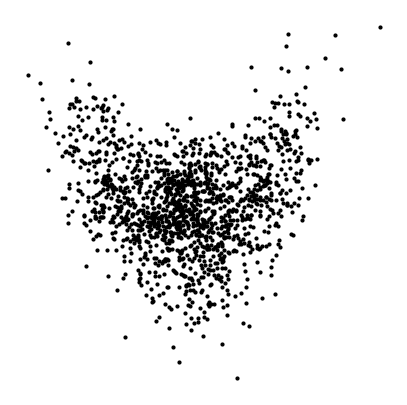

In [93]:

def sample_scores(n = 800):
    S1 = np.array([[6,-4],[-4,6]])
    S2 = np.array([[6,4],[4,6]])
    S3 = np.array([[2,0],[0,2]])
    Y1 = np.random.multivariate_normal([-4.5,0],S1,int(n*1/3))
    Y2 = np.random.multivariate_normal([4.5,0],S2,int(n*1/3))
    Y3 = np.random.multivariate_normal([0,0],S3,int(n*1/3))
    scores  = np.concatenate([Y1,Y2,Y3])
    idx = np.arange(len(scores)) 
    np.random.shuffle(idx) 
    scores = scores[idx] 
    return(scores) 

np.random.seed(62)
scores = sample_scores(n=1500)/10


import seaborn as sns 
sns.set_style("white")
# Plot: 
fig, ax = plt.subplots(figsize=(5,5))
plt.scatter(scores[:,0],scores[:,1],c="black",s=4)
plt.axis("off")


volume of MK region: 1.1331052510667359
volume rectangle: 1.3963511784861837
volume ellipse: 1.3627084868068167


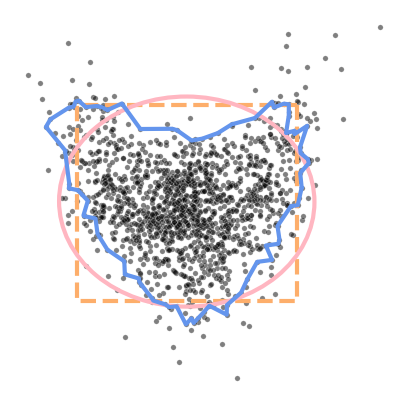

In [107]:
alpha = 0.9

# MK quantile region :
Quantile_Treshold,mu,psi,psi_star,ranksMK,Score_treshold = functions.MultivQuantileTreshold(scores,alpha=alpha) # solve OT 
contourMK = functions.get_contourMK(Quantile_Treshold,psi_star,scores)
print("volume of MK region:", functions.get_volume_QR(Quantile_Treshold,mu,psi,scores) )

# HYPERRECTANGLES : 
hyperrectangle = get_rectangle(scores,alpha)
print("volume rectangle:", get_vol_rectangle(scores,alpha) )

# ELLIPSOIDAL :
ellipsis = get_ellipse(scores,alpha)
print("volume ellipse:", get_vol_ellipse(scores,alpha) )

sns.set_style("white")

# Plot: 
fig, ax = plt.subplots(figsize=(5,5))
df = pd.DataFrame(scores,columns=["X1","X2"])
sns.scatterplot(df,x="X1",y="X2",c="black",s=15,alpha=0.5)#,c=ranksMK) 
plt.plot(contourMK.T[0],contourMK.T[1],color='cornflowerblue',linewidth=3)
#plt.scatter(Score_treshold[0],Score_treshold[1],c="red",s=100,marker="+") 
ax.add_patch(hyperrectangle)
ax.add_patch(ellipsis)
plt.axis("off")
#plt.savefig("quantiles_scores.pdf", format="pdf", bbox_inches="tight")

Now that we have the functions to compute volumes, we can repeat experiments to compare efficiency and coverage. 

## Comparison of coverage and efficiency

In [6]:

def LearnParameters(scores,alpha):
    ''' Learn parameters for MK quantiles, hyperrectangles, and ellipsoids. scores = data on which quantiles are computed. alpha = quantile level. '''
    #############################################
    ### MK : 
    Quantile_Treshold,mu,psi,psi_star,ranksMK,Score_treshold = functions.MultivQuantileTreshold(scores,alpha=alpha)
    ############################################# 
    ### Ellipsoids: 
    cov = np.cov(scores.T)
    cov_1 = np.linalg.inv(cov)
    MahalanobisNCM = -np.ones(len(scores)) # Mahalanobis Non-Conformity Measure
    for k in range(len(scores)):
        MahalanobisNCM[k] = scores[k].T @ cov_1 @ scores[k]
    OrderStatistics = np.argsort(MahalanobisNCM)
    q = alpha *(1+1/len(scores))
    indexTreshold = OrderStatistics[(int(q*len(scores))+1)]
    alpha_s = MahalanobisNCM[indexTreshold]

    ############################################# 
    ### Hyperrectangles : 
    componentwise_alpha = np.sqrt(alpha) 
    center_outward_m = (1 - componentwise_alpha)/2  
    list_axis = []
    for k in range(scores.shape[1]):
        axis = np.quantile(scores.T[k],[1-center_outward_m,center_outward_m]) 
        list_axis.append(axis) 
    list_axis = np.array(list_axis)
    return(Quantile_Treshold,mu,psi,psi_star,ranksMK,Score_treshold,alpha_s,cov,cov_1,list_axis)

In [7]:
from time import time
np.random.seed(62)
alpha = 0.9

#############################################
rates_cvg_MK = []
rates_cvg_rect = []
rates_cvg_ell = []
volumes_MK = []
volumes_rect = []
volumes_ell = [] 

for rep in range(50): 
    t0 = time()
    print(rep)
    # Sample calibration data 
    scores_cal = sample_scores(n=1000)/10 
    Quantile_Treshold,mu,psi,psi_star,ranksMK,Score_treshold,alpha_s,cov,cov_1,list_axis = LearnParameters(scores_cal,alpha)

    scores_test = sample_scores(n=1000)/10 
    # Compute MK quantile region coverage
    RankMK = functions.RankFunc(scores_test, mu, psi) 
    norm_RankMK = np.linalg.norm(RankMK, axis=1)
    coverageMK = np.mean(norm_RankMK <= Quantile_Treshold)

    # Compute hyperrectangle coverage
    within_lower_bounds = np.all(list_axis.T[1] <= scores_test, axis=1)
    within_upper_bounds = np.all(scores_test <= list_axis.T[0], axis=1)
    coverageRectangle = np.mean(within_lower_bounds & within_upper_bounds)

    # Compute Ellipse coverage
    MahalanobisNCM = np.einsum('ij,ji->i', scores_test @ cov_1, scores_test.T)
    # Efficient Mahalanobis calculation
    coverageEllipse = np.mean(MahalanobisNCM <= alpha_s)
    # Gather results
    rates_cvg_MK.append(coverageMK)
    rates_cvg_rect.append(coverageRectangle)
    rates_cvg_ell.append(coverageEllipse)

    # Volumes :
    # MK :
    volumes_MK.append(functions.get_volume_QR(Quantile_Treshold,mu,psi,scores_test,N = len(scores_test))) 
    # Rectangle: 
    lengths_sides = list_axis.T[0]-list_axis.T[1]
    volumes_rect.append( np.prod(lengths_sides)  )
    # Ellipse: 
    d = scores_test.shape[1] # The number of dimensions
    volume_unit_ball = np.pi**(d/2) / gamma(d/2 + 1)
    volumes_ell.append( np.linalg.det( cov*alpha_s )**(1/2) * volume_unit_ball )
    print(np.round(time()-t0,3) )


0
0.417
1
0.549
2
0.597
3
0.602
4
0.681
5
0.612
6
0.688
7
0.586
8
0.505
9
0.52
10
0.498
11
0.492
12
0.555
13
0.507
14
0.533
15
0.507
16
0.522
17
0.489
18
0.508
19
0.485
20
0.484
21
0.496
22
0.529
23
0.539
24
0.585
25
0.64
26
0.485
27
0.489
28
0.585
29
0.579
30
0.558
31
0.7
32
0.567
33
0.554
34
0.483
35
0.578
36
0.61
37
0.533
38
0.596
39
0.556
40
0.593
41
0.486
42
0.574
43
0.519
44
0.513
45
0.489
46
0.469
47
0.51
48
0.49
49
0.579


In [8]:
rates_cvg_MK = np.array(rates_cvg_MK)  
rates_cvg_rect = np.array(rates_cvg_rect)  
rates_cvg_ell = np.array(rates_cvg_ell)  
volumes_MK = np.array(volumes_MK)  
volumes_rect = np.array(volumes_rect)  
volumes_ell = np.array(volumes_ell)  

In [12]:
df

,X1,X2
0,0.211870,0.163061
1,-0.665182,-0.032171
2,-0.151369,-0.035855
3,-0.018856,-0.282739
4,-0.876342,0.016897
...,...,...
1495,0.664012,0.251119
1496,0.009394,0.105094
1497,0.168257,-0.307556
1498,-0.570148,0.411700


In [9]:
sns.set_style("whitegrid")

<Figure size 640x480 with 0 Axes>

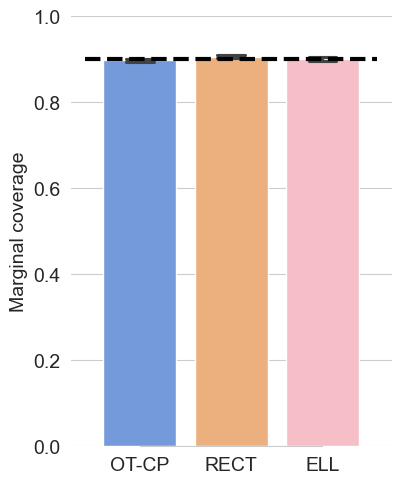

In [13]:

to_boxplot = np.array([rates_cvg_MK,rates_cvg_rect,rates_cvg_ell]).T 
df = pd.DataFrame(to_boxplot,columns=(["OT-CP","RECT","ELL"])) 

###########################

plt.figure()
g =sns.catplot( 
    data=df,  kind="bar",palette=["cornflowerblue",y2_color,"lightpink"],aspect=.8,capsize=0.3
        #x="Method", y="Coverage", palette=["cornflowerblue",y2_color,"lightpink"],height=2,width=0.8,capsize=0.3,aspect=1 #,hue_order=["IP","MS","APS","OTCP"]
)   
plt.hlines(alpha,xmin=-0.6,xmax=2.6,linewidth=3,linestyles="dashed",color="black") 
plt.ylim(0,1)
sns.despine(trim=True, left=True)
plt.ylabel("Marginal coverage") 
#plt.savefig("Coverage_reg_simu.pdf", format="pdf",bbox_inches="tight")
plt.show()



<Figure size 640x480 with 0 Axes>

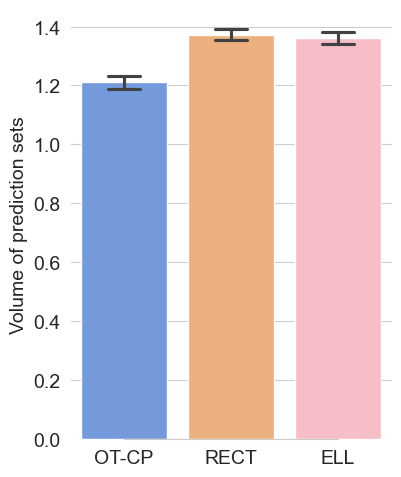

In [14]:
to_boxplot = np.array([volumes_MK,volumes_rect,volumes_ell]).T  
df = pd.DataFrame(to_boxplot,columns=(["OT-CP","RECT","ELL"])) 

plt.figure()
g =sns.catplot( 
    data=df,  kind="bar",palette=["cornflowerblue",y2_color,"lightpink"],aspect=0.8,capsize=0.3
        #x="Method", y="Coverage", palette=["cornflowerblue",y2_color,"lightpink"],height=2,width=0.8,capsize=0.3,aspect=1 #,hue_order=["IP","MS","APS","OTCP"]
)   
sns.despine(trim=True, left=True)
plt.ylabel("Volume of prediction sets")  
#plt.savefig("Efficiency_reg_simu.pdf", format="pdf",bbox_inches="tight")
plt.show()

#### All the previous computations have been made on scores independently of $X$. 
#### This amounts to suppose that the noise is independent from $X$. 
#### The next cell uses codes for quantile regression to visualize the impact in terms of prediction regions (around a prediction $\hat{f}$)

In [15]:

def QuantileKn_d(x, y, n, x_tick,k,levels):
    ''' compute MK quantile contours conditional on x_tick, based on the calibration data x,y  '''
    ### x=covariates 
    ### y=output variables
    ### n= number of neighbors 
    ### x_tick = list of points x where the conditional quantile function Q( . / X = x) is to be computed 
    ### k number of points in quantile contour
    ### levels : contour levels to be computed, each between 0 and 1 

    x = np.array(x)
    y = np.array(y)    

    ## uniform grid
    d = y.shape[1]
    U = functions.sample_grid(np.zeros((n,d)))

    ## Compute quantile contours, for each x
    for i in range(len(x_tick)):
        X = np.zeros(n)
        ### select n-nearest neighbors
        order = np.argsort(np.linalg.norm(x-x_tick[i],axis=1) )
        X = x[order][:n]
        Y = y[order][:n]

        psi_star = functions.OT_exact_(U,Y) ## POT with scaling/rescaling  
        
        quantile_contours = []
        for alpha in levels:
            sphere = np.random.multivariate_normal(np.zeros(d),np.eye(d),k)
            sphere = sphere / np.linalg.norm(sphere,axis=1).reshape((k,1))
            quantile_contours.append( functions.T0(alpha*sphere , Y ,psi_star) )
        quantile_contours = np.array(quantile_contours)
    return(quantile_contours)



def PlotQuantile3D(x , y, z,quantile, quantile2,quantile3,center,NumberOfGrid,ContourLength):
    fig = plt.figure(figsize=(7,7))
    ax = fig.add_subplot(projection='3d')
    ax.scatter3D(x, y, z, color='gray',s=30,alpha=0.2,label="Test samples")
    ax.set_xlabel('X',fontsize=15)
    ax.set_ylabel('$Y_1$',fontsize=15)
    ax.set_zlabel('$Y_2$',fontsize=15)
    #Plot the centers
    ax.plot3D(center[:,0],center[:,1],center[:,2], 'cornflowerblue',alpha = 1, 
              linewidth=3.0,linestyle='-.',zorder=5,label="Prediction $\hat{f}(x)$")
    for k in range(NumberOfGrid):
        si=ContourLength
        r1=k*(si)
        r2=(si)*(k+1)
        q1=np.zeros((si+1,3))
        q1[0:si,:]=quantile[r1:r2,:]
        q1[si,:]=quantile[r1,:]
        q1=np.zeros((si+1,3))
        q1[0:si,:]=quantile2[r1:r2,:]
        q1[si,:]=quantile2[r1,:]
        q1=np.zeros((si+1,3))
        q1[0:si,:]=quantile3[r1:r2,:]
        q1[si,:]=quantile3[r1,:]
        if k==0:
            ax.plot3D(q1[:,0],q1[:,1],q1[:,2],'cornflowerblue',alpha = 1, linewidth=2.0,zorder=2,label="MK prediction sets")
        else:
            ax.plot3D(q1[:,0],q1[:,1],q1[:,2],'cornflowerblue',alpha = 1, linewidth=2.0,zorder=2)
    ax.set_box_aspect(None, zoom=0.9)
    plt.legend(loc='center left', bbox_to_anchor=(0.13, 0.75))
    
    

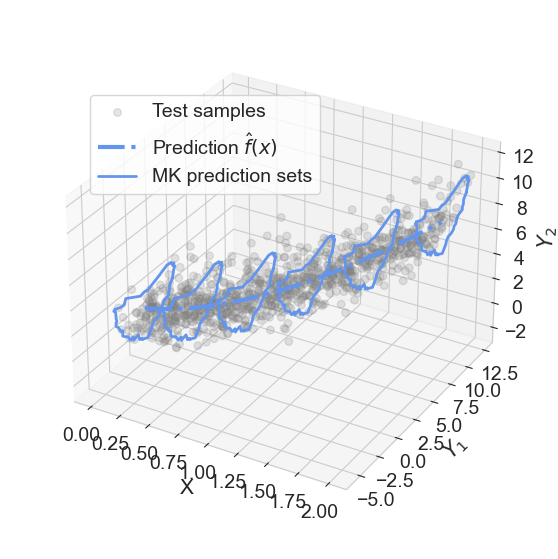

In [16]:
n_sample = 999
x = np.linspace(0,2,n_sample)
noise = sample_scores(n_sample)/2

Y = np.array([ 2*x**2, (x+1)**2]).T + noise
y = Y.T[0]
z = Y.T[1]
k = 100 # number of points in a contour 
grid = 6
levels = np.array([0.2,0.5,0.8])

### predictor
BayesRegressor = np.array([x, 2*x**2, (x+1)**2]).T 

### Quantile computation 
d = Y.shape[1]
scores = Y - BayesRegressor[:,1:]
U = functions.sample_grid(scores)
psi, psi_star = functions.learn_psi(U,scores)

sphere = np.array([np.cos(2*np.pi*np.arange(k)/k),np.sin(2*np.pi*np.arange(k)/k)]).T
quantile_contours = []
for alpha in levels:
    quantile_contours.append( functions.T0(alpha*sphere , scores ,psi_star) )
quantile_contours = np.array(quantile_contours)

### x mesh
indices_grid = np.array( np.linspace(0,0.999,grid)*len(x) ,dtype=int)
x_tick = x[indices_grid]


quantiles = []
for i in range(len(levels)):
    g = 0
    Q0 = quantile_contours[i] + BayesRegressor[:,1:][indices_grid][g] 
    BayesRegressor[indices_grid] 
    quantile1 = np.array([np.repeat(x_tick[g] ,k),Q0.T[0],Q0.T[1]]).T 
    for g in range(1,grid):
        Q0 = quantile_contours[i] + BayesRegressor[:,1:][indices_grid][g] 
        Q0x = np.array([np.repeat(x_tick[g] ,k),Q0.T[0],Q0.T[1]]).T 
        quantile1 = np.concatenate([quantile1,Q0x])
    quantiles.append(quantile1)
quantile1, quantile2, quantile3 = quantiles 

PlotQuantile3D(x,y,z,quantile1, quantile2, quantile3, BayesRegressor,grid,k) 
#plt.savefig("HomoscedasticNoise.pdf", format="pdf",bbox_inches="tight")
plt.show()

 We now turn to adaptive regions via quantile regression on scores 
 
 # Heteroscedastic noise, the general case 

We begin with an example with $X\in\mathbb{R}$ and $Y\in\mathbb{R}^2$, in order to vizualise the results.


In [17]:

def ConformalQuantileKn(x, y, n, x_tick,k,alpha):
    ''' To plot quantile contours with 3D visualisation '''
    ### x=covariates 
    ### y=output variables
    ### n= number of neighbors 
    ### x_tick = list of points x where the conditional quantile function Q( . / X = x) is to be computed 
    ### k number of points in quantile contour
    ### levels : contour levels to be computed, each between 0 and 1 

    x = np.array(x)
    y = np.array(y)    

    ## uniform grid
    d = y.shape[1]
    U = functions.sample_grid(np.zeros((n,d)))

    quantile_contours = []
    ## Compute quantile contours, for each x
    for i in range(len(x_tick)):
        X = np.zeros(n)
        ### select n-nearest neighbors
        order = np.argsort(np.linalg.norm(x-x_tick[i],axis=1) )
        scores = scores[order][:n]

        Quantile_Treshold,mu,psi,psi_star,ranksMK,Score_treshold = functions.MultivQuantileTreshold(scores,alpha=alpha)
        
        sphere = np.array([np.cos(2*np.pi*np.arange(k)/k),np.sin(2*np.pi*np.arange(k)/k)]).T
        quantile_contours.append( functions.T0(Quantile_Treshold*sphere , scores ,psi_star) ) 
    return(np.array(quantile_contours)) 

def get_metricsMK(newdata,mu,psi,Quantile_Treshold,scores):
    # Compute MK quantile region coverage :
    RanksMK = functions.RankFunc(newdata, mu, psi) 
    norm_RankMK = np.linalg.norm(RanksMK, axis=1)
    coverageMK = np.mean(norm_RankMK <= Quantile_Treshold)
    # Compute volume of MK quantile region :
    volumeMK = functions.get_volume_QR(Quantile_Treshold,mu,psi,scores) 
    return(coverageMK,volumeMK) 

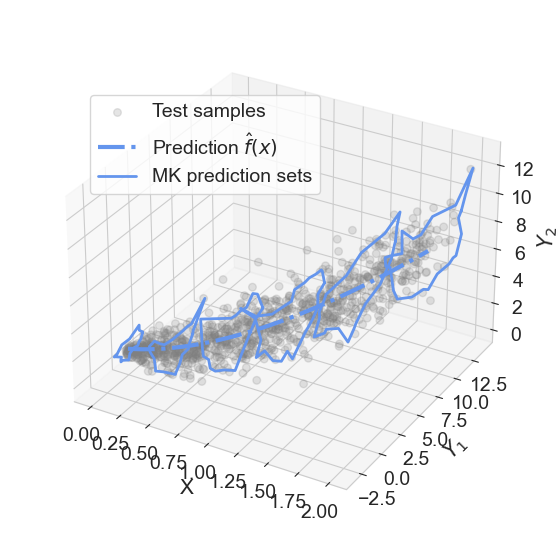

In [ ]:
n_sample = 999
x = np.linspace(0,2,n_sample)
noise2 = sample_scores(n_sample)/2
Y = np.array([ 2*x**2, (x+1)**2]).T  + noise2*np.sqrt(x).reshape(n_sample,1)
y = Y.T[0] 
z = Y.T[1] 
n = 100 # number of neighbors

k = 100 # number of points in a contour 
grid = 6
alpha = 0.9

### predictor
BayesRegressor = np.array([x, 2*x**2, (x+1)**2]).T 

### Quantile computation 
d = Y.shape[1] 
U = functions.sample_grid(np.zeros((n,d)))  
 
### x mesh
indices_grid = np.array( np.linspace(0,0.999,grid)*len(x) ,dtype=int) 
x_tick = x[indices_grid] 

sphere = np.array([np.cos(2*np.pi*np.arange(k)/k),np.sin(2*np.pi*np.arange(k)/k)]).T 
quantile_contours = [] 
for i in range(grid): 
    ### select n-nearest neighbors  
    scores = Y - BayesRegressor[:,1:] 
    order = np.argsort(np.abs(x-x_tick[i]) ) 
    scores = scores[order][:n] 
    # Solve OT 
    Quantile_Treshold,mu,psi,psi_star,ranksMK,Score_treshold = functions.MultivQuantileTreshold(scores,alpha=alpha)
    # Compute quantile contour 
    Q0 = functions.T0(Quantile_Treshold*sphere , scores ,psi_star) 
    quantile_contours.append( Q0 ) 
quantile_contours = np.array(quantile_contours) 

quantiles = []
g = 0 
Q0 = quantile_contours[g] + BayesRegressor[:,1:][indices_grid][g] 
BayesRegressor[indices_grid] 
quantile1 = np.array([np.repeat(x_tick[g] ,k),Q0.T[0],Q0.T[1]]).T 
for g in range(1,grid):
    Q0 = quantile_contours[g] + BayesRegressor[:,1:][indices_grid][g] 
    Q0x = np.array([np.repeat(x_tick[g] ,k),Q0.T[0],Q0.T[1]]).T 
    quantile1 = np.concatenate([quantile1,Q0x])

quantile1, quantile2, quantile3 = quantile1,quantile1,quantile1 

PlotQuantile3D(x,y,z,quantile1, quantile2, quantile3, BayesRegressor,grid,k) 
#plt.savefig("HeteroscedasticNoise.pdf", format="pdf",bbox_inches="tight")
plt.show()

We now evaluate conditional coverage on this toy-example. 

In [20]:
np.random.seed(62)
####### SAMPLE CALIBRATION DATA 
n_sample = 999 

alpha = 0.9 
Nrep = 100 # Proportion of test data in the prediction region is repeated `Nrep`` times 
n_test = 999 # n_test new data points in testing data 
k = 100 #  # number of neigbors to compute Quantile regression function   

########################################################
####### Assess coverage on an interval (a,b)
########################################################
a,b = 0.25,0.5 # interval on which to sample 
res = - np.ones(Nrep)
for rep in range(Nrep):
    ####### SAMPLE CALIBRATION DATA 
    x = np.linspace(0,2,n_sample) 
    noise2 = sample_scores(n_sample)/2 
    y = np.array([ 2*x**2, (x+1)**2]).T  + noise2*np.sqrt(x).reshape(n_sample,1)
    BayesRegressor = np.array([2*x**2, (x+1)**2]).T 
    scores = y - BayesRegressor 
    x = x.reshape(-1, 1) 

    ####### SAMPLE TEST DATA IN THE INTERVAL (a,b) and compute scores on this test data
    X_test = np.linspace(a,b,n_test)
    noise2 = sample_scores(n_test)/2
    Y_test =  np.array([ 2*X_test**2, (X_test+1)**2]).T  + noise2*np.sqrt(X_test).reshape(n_test,1)
    BayesRegressor = np.array([2*X_test**2, (X_test+1)**2]).T 
    Stest = Y_test - BayesRegressor

    ####### Conformal multivariate regression 
    coverage_conditional_X_test = []
    for i,x_tick in enumerate(X_test): # for each new testing point x_tick 
        Quantile_Treshold, mu, psi,psi_star = functions.ConformalQuantileReg(x,scores, k, x_tick,alpha) # compute conditional rank map on calibration data
        Ranks_Stest = functions.RankFunc(Stest[i],mu,psi)  # apply this conditional rank map to the score associated to x_tick 
        coverage_conditional_X_test.append( 1*(np.linalg.norm(Ranks_Stest) <= Quantile_Treshold) ) # verify if the test data points belongs to the quantile region
    coverage_conditional_X_test = np.array(coverage_conditional_X_test) 
    res[rep] = np.mean( coverage_conditional_X_test )
res1 = res

print("1 ok ")

########################################################
####### Assess coverage on an another interval (a,b)
########################################################
a,b = 1.5,2 # interval on which to sample 
res = - np.ones(Nrep)
for rep in range(Nrep):
    ####### SAMPLE CALIBRATION DATA 
    x = np.linspace(0,2,n_sample) 
    noise2 = sample_scores(n_sample)/2 
    y = np.array([ 2*x**2, (x+1)**2]).T  + noise2*np.sqrt(x).reshape(n_sample,1)
    BayesRegressor = np.array([2*x**2, (x+1)**2]).T 
    scores = y - BayesRegressor 
    x = x.reshape(-1, 1) 
    ####### SAMPLE TEST DATA IN THE INTERVAL (a,b) and compute scores on this test data
    X_test = np.linspace(a,b,n_test)
    noise2 = sample_scores(n_test)/2
    Y_test =  np.array([ 2*X_test**2, (X_test+1)**2]).T  + noise2*np.sqrt(X_test).reshape(n_test,1)
    BayesRegressor = np.array([2*X_test**2, (X_test+1)**2]).T 
    Stest = Y_test - BayesRegressor

    ####### Conformal multivariate regression 
    coverage_conditional_X_test = []
    for i,x_tick in enumerate(X_test): # for each new testing point x_tick 
        Quantile_Treshold, mu, psi,psi_star = functions.ConformalQuantileReg(x,scores, k, x_tick,alpha) # compute conditional rank map on calibration data
        Ranks_Stest = functions.RankFunc(Stest[i],mu,psi)  # apply this conditional rank map to the score associated to x_tick 
        coverage_conditional_X_test.append( 1*(np.linalg.norm(Ranks_Stest) <= Quantile_Treshold) ) # verify if the test data points belongs to the quantile region
    coverage_conditional_X_test = np.array(coverage_conditional_X_test) 
    res[rep] = np.mean( coverage_conditional_X_test )
res2 = res 

print("2 ok ")

########################################################
####### Assess coverage on an another interval (a,b)
########################################################
a,b = 0,2 # interval on which to sample 
res = - np.ones(Nrep)
for rep in range(Nrep):
    ####### SAMPLE CALIBRATION DATA 
    x = np.linspace(0,2,n_sample) 
    noise2 = sample_scores(n_sample)/2 
    y = np.array([ 2*x**2, (x+1)**2]).T  + noise2*np.sqrt(x).reshape(n_sample,1)
    BayesRegressor = np.array([2*x**2, (x+1)**2]).T 
    scores = y - BayesRegressor 
    x = x.reshape(-1, 1) 
    ####### SAMPLE TEST DATA IN THE INTERVAL (a,b) and compute scores on this test data
    X_test = np.linspace(a,b,n_test)
    noise2 = sample_scores(n_test)/2
    Y_test =  np.array([ 2*X_test**2, (X_test+1)**2]).T  + noise2*np.sqrt(X_test).reshape(n_test,1)
    BayesRegressor = np.array([2*X_test**2, (X_test+1)**2]).T 
    Stest = Y_test - BayesRegressor

    ####### Conformal multivariate regression 
    coverage_conditional_X_test = []
    for i,x_tick in enumerate(X_test): # for each new testing point x_tick 
        Quantile_Treshold, mu, psi,psi_star = functions.ConformalQuantileReg(x,scores, k, x_tick,alpha) # compute conditional rank map on calibration data
        Ranks_Stest = functions.RankFunc(Stest[i],mu,psi)  # apply this conditional rank map to the score associated to x_tick 
        coverage_conditional_X_test.append( 1*(np.linalg.norm(Ranks_Stest) <= Quantile_Treshold) ) # verify if the test data points belongs to the quantile region
    coverage_conditional_X_test = np.array(coverage_conditional_X_test) 
    res[rep] = np.mean( coverage_conditional_X_test )
resmarginal = res 


1 ok 
2 ok 


<Figure size 640x480 with 0 Axes>

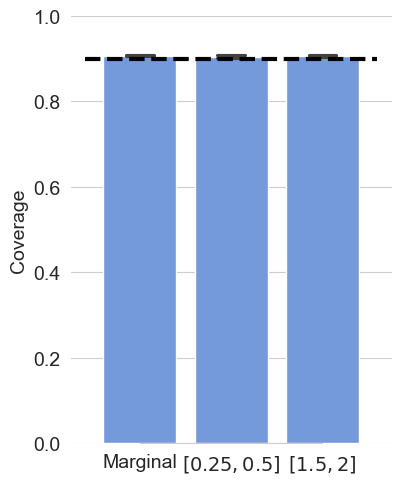

In [21]:
to_boxplot = np.array([resmarginal,res1,res2]).T  
df = pd.DataFrame(to_boxplot,columns=(["Marginal","$[0.25,0.5]$","$[1.5,2]$"])) 

plt.figure()
g =sns.catplot( 
    data=df,  kind="bar",palette=["cornflowerblue","cornflowerblue","cornflowerblue"],aspect=.8,capsize=0.3
)   
plt.hlines(alpha,xmin=-0.6,xmax=2.6,linewidth=3,linestyles="dashed",color="black") 
plt.ylim(0,1)
sns.despine(trim=True, left=True)
plt.ylabel("Coverage") 
#plt.savefig("SimuConditionalCVG.pdf", format="pdf",bbox_inches="tight")
plt.show()

# Analysis of Real data 

In [22]:

from scipy.io import arff
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor

In [116]:
########### LOAD DATA 

list_data = ["enb","atp1d","jura","rf1","wq","scm20d"] 
dim_targets =  [2,6,7,8,14,16]

m = 5
arff_file = arff.loadarff('./data/{}.arff'.format(list_data[m])) 
df = pd.DataFrame(arff_file[0]).dropna()
print(df.head()) 

## Extract target variable y 
df = np.array(df) 
tt = df.shape[1] - dim_targets[m]
x = df[:,:tt] 
y = df[:,tt:] 
print("Amount of data:", x.shape,y.shape) 


   timeunit  storageCost  interestRate  compidx0lt2  compidx4lt2  compidx6lt2  \
0       9.0         27.0           8.0      881.606      276.589      283.096   
1      10.0         27.0           8.0      869.455      288.277      271.252   
2      11.0         27.0           8.0      850.916      288.429      271.573   
3      12.0         27.0           8.0      862.066      290.866      268.637   
4      13.0         27.0           8.0      842.781      278.185      270.078   

   compidx8lt2  compidx10lt2  compidx12lt2  compidx14lt2  ...  MTLp7A  MTLp8A  \
0      113.193       108.831       247.377       228.541  ...  1747.0  1905.0   
1      116.232       109.822       250.485       222.397  ...  1794.0  2060.0   
2      116.703       108.636       252.319       218.822  ...  1774.0  1876.0   
3      117.098       109.253       257.071       204.266  ...  1760.0  1820.0   
4      116.822       105.997       257.858       213.514  ...  1780.0  1846.0   

   MTLp9A  MTLp10A  MTLp11

In [67]:
M = np.max(scores,axis=0)
m = np.min(scores,axis=0)
v = m + np.random.random((N,len(M)))*(M-m) 
scale = np.prod(M-m)  
MCMC = np.mean(np.linalg.norm( RankFunc(v,mu,psi) ,axis=1) <= Quantile_Treshold) 

2

### The next cell defines the needed functions for MK conditional quantiles :

In [37]:

def test_content_conditionalQR(xtest,stest,x,scores,alpha=0.9,n=100):
    ''' xtest is one observation from X-space, and stest is the associated ground-truth score.
     x,y,scores are the calibration data with previously computed scores. required for knn step. n = number of neighbors for conditional QR. '''
    ########### get conditional quantiles and ranks 
    Quantile_Treshold, mu, psi,psi_star = functions.ConformalQuantileReg(x,scores, n=n, x_tick=xtest,alpha=alpha) 
    volume_QR = functions.get_volume_QR(Quantile_Treshold,mu,psi,scores) 
    ########### evaluate our prediction region by verifying if it contains the ground truth 
    Ranks_Stest = functions.RankFunc(stest,mu,psi)
    indic_content = 1*(np.linalg.norm(Ranks_Stest) <= Quantile_Treshold) 
    return indic_content,volume_QR

def SetCoverage(x,scores,Xtest,Stest,alpha=0.9,n=100):
    ''' Run test_content_conditionalQR over the dataset Xtest.  
    - x,scores correspond to calibration data, to learn MK quantiles on it. 
    Returns the proportion of Ytest that are effectively in our conditional prediction set. '''
    prop = 0
    average_volume = 0
    for i in range(len(Xtest)):
        xtest = Xtest[i] 
        stest = Stest[i] 
        indic_content,volume_QR = test_content_conditionalQR(xtest,stest,x,scores,alpha=alpha,n=n)
        prop += indic_content 
        average_volume += volume_QR
    prop = prop / len(Xtest)
    average_volume = average_volume / len(Xtest)
    return(prop,average_volume)

def WorstSetCoverage(x,scores,Xtest,Stest,alpha=0.9,n=100,n_neighbors=100):
    '''
    This functions selects 5 random subsets Ai of Xtest, on which it estimates conditional coverage, before taking the minimal coverage value (the worst case scenario). 
    Each subset Ai is selected by a random choice of point (and its n neighbors) within Xtest. 

    - x,y,scores shall come from calibration data : they are used for computation of MK quantiles 
    - Xtest and Stest = test data, on which to evaluate empirical coverage  
    - n = number of points in subset Ai 
    - n_neighbors = number of neighbors to compute MK quantile regression,  
    '''
    # choice of some points in Xtest, that will serve as centers to define subsets 
    random_idx = np.random.randint(len(Xtest),size=5) 
    # For each, define a neighborood Ai and compute empirical coverage on it 
    list_coverage_Ai = - np.ones(len(random_idx))
    list_average_volume_Ai = - np.ones(len(random_idx))
    for i,idx in enumerate(random_idx):
        ### select nn-nearest neighbors
        if len(x.shape)>1:
            norms_ranks = np.linalg.norm(Xtest-Xtest[idx],axis=1)
        else:
            norms_ranks = np.abs(Xtest-Xtest[idx])
        order = np.argsort(norms_ranks )
        Ai = Xtest[order][:n] 
        Scores_Ai = Stest[order][:n] 
        Coverage_Ai,average_volume = SetCoverage(x,scores,Xtest=Ai,Stest=Scores_Ai,alpha=alpha,n=n_neighbors)
        list_coverage_Ai[i] = Coverage_Ai
        list_average_volume_Ai[i] = average_volume

    return( np.min(list_coverage_Ai),list_average_volume_Ai )

#### Define functions for ellispoids :

In [38]:
from ellipsoidal_conformal_utilities import (
    ellipsoidal_non_conformity_measure,
    ellipse_global_alpha_s,
    ellipse_local_alpha_s,
    local_ellipse_validity_efficiency,
    ellipse_volume
)

def get_params_localEllipsoids(X_cal,y_cal,y_pred_cal,alpha,n_neighbors):
    ''' For confidence level alpha, learn mixture of local and global covariance on  '''
    lam = 0.95 # lambda parameter for mixing local and global covariance
    cov_train, alpha_s = ellipse_global_alpha_s(
        y_true_train = y_cal,
        y_pred_train = y_pred_cal, 
        y_true_cal = y_cal, 
        y_pred_cal = y_pred_cal, 
        epsilon = 1-alpha
    )
    knn, local_alpha_s = ellipse_local_alpha_s(
        x_train = X_cal,
        x_cal = X_cal,
        y_true_train = y_cal,
        y_pred_train = y_pred_cal,
        y_true_cal = y_cal,
        y_pred_cal = y_pred_cal,
        epsilon = 1-alpha,
        n_neighbors = n_neighbors,
        lam = lam,
        cov_train = cov_train
    )
    return(cov_train,knn, local_alpha_s )

def SetCoverage_ell(X_cal,y_cal,y_pred_cal,X_test,y_test,y_pred_test,alpha,n_neighbors):
    # 1) KNN step : get 'n_neighbors' nearest neighbors of each X_test[i] in X_cal
    knn = NearestNeighbors(n_neighbors=n_neighbors)
    knn.fit(X_cal)
    local_neighbors_test = knn.kneighbors(X_test, return_distance=False) 

    # 2) learn local ang global covariance on calibration data, and get the calibrated treshold: 'local_alpha_s'
    cov_train,knn, local_alpha_s = get_params_localEllipsoids(X_cal,y_cal,y_pred_cal,alpha,n_neighbors) 
    
    # 3) compute validity on test data :
    ### y_cal and  y_pred_cal are required to compute calibration scores and extract the indices corresponding to 'local_neighbors_test'
    normalized_ellipse_validity, normalized_ellipse_efficiency, = local_ellipse_validity_efficiency(
                local_neighbors_test=local_neighbors_test,
                y_true_test = y_test,
                y_pred_test = y_pred_test,
                y_true_train = y_cal,
                y_pred_train = y_pred_cal,
                local_alpha_s = local_alpha_s,
                dim=y_cal.shape[1],
                lam=0.95,
                cov_train = cov_train
        )
    return( normalized_ellipse_validity/100, normalized_ellipse_efficiency )

def WorstSetCoverage_Ellipsoids(x,y,Xtest,Ytest,parameters_ell,nn=100):
    '''
    - x,y,scores shall come from calibration data : they are used for computation of MK quantiles 
    - Xtest and Stest = test data, on which to evaluate empirical coverage  
    - nn = number of neighbors to define size of Ai 
    - parameters_ell already contains knn, an object that has contains the number n_neighbors of neighbors for adaptive knn-based covariances computations on the calibration data. 
    '''
    knn,y_pred_test,y_pred_train,local_alpha_s,lam,cov_train = parameters_ell
    # choice of some points in Xtest, that will serve as centers to define subsets 
    random_idx = np.random.randint(len(Xtest),size=5) 
    # For each, define a neighborood Ai and compute empirical coverage on it 
    list_coverage_Ai = - np.ones(len(random_idx))
    list_average_volume_Ai = - np.ones(len(random_idx))
    for i,idx in enumerate(random_idx):
        ### select nn-nearest neighbors 
        if len(x.shape)>1:
            norms_ranks = np.linalg.norm(Xtest-Xtest[idx],axis=1)
        else:
            norms_ranks = np.abs(Xtest-Xtest[idx])
        order = np.argsort(norms_ranks )
        Ai = Xtest[order][:nn] 
        Yi = Ytest[order][:nn] 
        hatf_Xi = y_pred_test[order][:nn] 
        ### Evaluate coverage on Ai 
        local_neighbors_test = knn.kneighbors(Ai, return_distance=False) 
        normalized_ellipse_validity, normalized_ellipse_efficiency, = local_ellipse_validity_efficiency(
                local_neighbors_test,
                Yi,
                hatf_Xi,
                y,
                y_pred_train,
                local_alpha_s,
                y.shape[1],
                lam,
                cov_train
        )
        list_coverage_Ai[i] = normalized_ellipse_validity /100
        list_average_volume_Ai[i] = normalized_ellipse_efficiency

    return( np.min(list_coverage_Ai),np.mean(list_average_volume_Ai) )

# Low-Medium sample setting 
## Experiments are pursued with datasets of less than 1500 total observations (otherwise truncated). 

In [ ]:
np.random.seed(62)
# Repeated experiments 
########### LOAD DATA 
list_data = ["enb","atp1d","jura","rf1","wq","scm20d"] 
dim_targets =  [2,6,7,8,14,16,16,16]

alpha = 0.9
t0 = time() 

Nrep = 10

list_RESULTS_coverage = []
list_RESULTS_coverage2 = []
list_RESULTS_volume = []
for m in range(len(dim_targets)):
    # Load data 
    arff_file = arff.loadarff('./data/{}.arff'.format(list_data[m])) 
    df = pd.DataFrame(arff_file[0]).dropna()

    # Separate explanatory and target variable (x,y) 
    df = np.array(df) 
    tt = df.shape[1] - dim_targets[m]
    x = df[:1500,:tt] 
    y = df[:1500,tt:] 
    print("size calibration data:",x.shape[0]/4)

    # For robust results, repeat 'Nrep' times a random splitting of the data 
    WorstCoverage_rep = -np.ones(Nrep) 
    Average_volume_rep =  -np.ones(Nrep) 
    WorstCoverage_rep_ell =  -np.ones(Nrep) 
    Average_volume_rep_ell = -np.ones(Nrep) 
    MarginalCoverage = - np.ones(Nrep) 
    MarginalCoverage_ell = -np.ones(Nrep) 
    for rep in range(Nrep): 
        print(m,rep,":",np.round(time()-t0,3) )
        #######################################
        ## Split Train / Calibration / Test 
        #######################################
        X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.5)
        X_test, X_cal, y_test, y_cal = train_test_split(X_test, y_test, test_size=0.5)

        ## Learn regressor on Train data 
        model = RandomForestRegressor()
        model.fit(X_train,y_train)

        ## Evaluate scores on Calibration data and on Test data 
        y_pred_cal = model.predict(X_cal) 
        S_cal = y_cal - y_pred_cal 
        y_pred_test = model.predict(X_test) 
        Stest = y_test - y_pred_test 

        ## Choose a number of neighbors for KNN. Both methods use this, to estimate conditional distribution Y/X=x.
        n_neighbors = int(len(X_cal)*0.1) 

        #######################################
        # MARGINAL COVERAGE : 
        ########################################
        NumberTestDataSet = len(X_test) # With low-medium datasets, this is the appropriate choice. Otherwise, take less than len(X_test) to accelerate computations (there is one OT problem for each Xtest, each OT problem being between point clouds with n_neighbors points)
        indices = np.random.choice(len(X_test),NumberTestDataSet )

        ## COMPUTE MK quantiles on calibration data and get metrics on test data 
        MarginalCoverage[rep],average_volume = SetCoverage(X_cal,S_cal,X_test[indices],Stest[indices],alpha=alpha,n=n_neighbors)
        
        ## COMPUTE ELLIPSOIDS on calibration data and get metrics on test data 
        MarginalCoverage_ell[rep], normalized_ellipse_efficiency = SetCoverage_ell(X_cal,y_cal,y_pred_cal,X_test[indices],y_test[indices],y_pred_test[indices],alpha,n_neighbors=n_neighbors)

        ########################################
        # WORST SET COVERAGE : 
        ########################################
        ## Choose a number of neighbors for subsets Ai, when computing Worst Set coverage. 
        nn = int(len(X_cal)*0.1) # size of the five subsets to compute worst set coverage 
        WorstCoverage_test,list_average_volume_Ai = WorstSetCoverage(X_cal,S_cal,X_test,Stest,alpha=alpha,n=nn,n_neighbors=n_neighbors)
        WorstCoverage_rep[rep] = WorstCoverage_test 
        Average_volume_rep[rep] = np.mean( list_average_volume_Ai ) 
        ## Compute Local ellipsoidal scores on calibration data and get metrics on test data 
        lam = 0.95 # lambda parameter in their paper 
        cov_train, alpha_s = ellipse_global_alpha_s(y_cal, y_pred_cal, y_cal, y_pred_cal, 1-alpha) 
        knn, local_alpha_s = ellipse_local_alpha_s(X_cal,X_cal,y_cal,y_pred_cal,y_cal,y_pred_cal,1-alpha,n_neighbors,lam,cov_train)
        parameters_ell = [knn,y_pred_test,y_pred_cal,local_alpha_s,lam,cov_train]
        WorstCoverage_rep_ell[rep], Average_volume_rep_ell[rep] = WorstSetCoverage_Ellipsoids(X_cal,y_cal,X_test,y_test,parameters_ell,nn=nn) 


    # For each data, we gather the results in a suitable form for future visualisations 
    WorstCoverages = np.concatenate([WorstCoverage_rep,WorstCoverage_rep_ell])
    methods = np.concatenate([np.repeat("MK",Nrep),np.repeat("Ell",Nrep)])
    name_data = np.repeat(list_data[m],Nrep*2)
    df1 = np.array([WorstCoverages,methods,name_data]).T 
    list_RESULTS_coverage.append( df1 )

    MarginalCoverages = np.concatenate([MarginalCoverage,MarginalCoverage_ell])
    df1 = np.array([MarginalCoverages,methods,name_data]).T 
    list_RESULTS_coverage2.append( df1 )

    Volumes = np.concatenate([Average_volume_rep,Average_volume_rep_ell])
    df2 = np.array([Volumes,methods,name_data]).T 
    list_RESULTS_volume.append( df2 )
    print(m,":",np.round(time()-t0,3) )


In [140]:
#############################################
# We transform results in DataFrame format:
#############################################

######### Worst Set Coverage 
df_results_coverage = list_RESULTS_coverage[0] 
for i in range(1,len(list_RESULTS_coverage)):
    df_results_coverage = np.concatenate([df_results_coverage,list_RESULTS_coverage[i] ])
df_results_coverage = pd.DataFrame(df_results_coverage,columns=["Worst Set Coverage","Method","Data"])
df_results_coverage = df_results_coverage.astype({'Worst Set Coverage': 'float'})
df_results_coverage['Method'] = df_results_coverage['Method'].apply(lambda x: "OT-CP" if x =="MK" else "ELL")

######### Marginal Coverage  
df_results_coverage2 = list_RESULTS_coverage2[0] 
for i in range(1,len(list_RESULTS_coverage2)):
    df_results_coverage2 = np.concatenate([df_results_coverage2,list_RESULTS_coverage2[i] ])
df_results_coverage2 = pd.DataFrame(df_results_coverage2,columns=["Coverage","Method","Data"])
df_results_coverage2 = df_results_coverage2.astype({'Coverage': 'float'})
df_results_coverage2['Method'] = df_results_coverage2['Method'].apply(lambda x: "OT-CP" if x =="MK" else "ELL")

######### Average volume
df_results_volume= list_RESULTS_volume[0] 
for i in range(1,len(list_RESULTS_volume)):
    df_results_volume = np.concatenate([df_results_volume,list_RESULTS_volume[i] ])
df_results_volume = pd.DataFrame(df_results_volume,columns=["Volume","Method","Data"]) 
df_results_volume = df_results_volume.astype({'Volume': 'float'}) 
df_results_coverage2['Method'] = df_results_coverage2['Method'].apply(lambda x: "OT-CP" if x =="MK" else "ELL")

#################
# We save the results 
#df_results_coverage.to_csv('reg_mediumdata_realdata_WorstCoverages.csv', index=False) 
#df_results_coverage2.to_csv('reg_mediumdata_realdata_MarginalCoverages.csv', index=False) 
#df_results_volume.to_csv('reg_mediumdata_realdata_Volumes.csv', index=False) 

<Figure size 640x480 with 0 Axes>

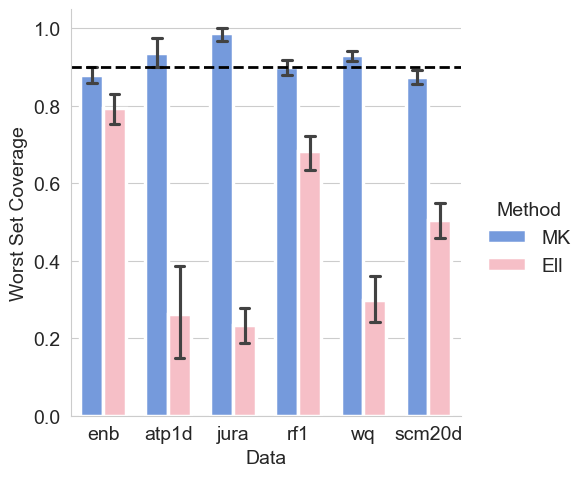

In [157]:
#df_results_coverage = pd.read_csv('reg_mediumdata_realdata_WorstCoverages.csv') 

plt.figure()
g =sns.catplot( 
        data=df_results_coverage,  kind="bar",
        x="Data", y="Worst Set Coverage", hue="Method", palette=["cornflowerblue","lightpink"],height=5,width=0.7,capsize=0.3,aspect=1,linewidth=2.5,legend=["OT-CP","ELL"]
)   
g.refline(y=alpha, color='black',linestyle="dashed",linewidth=2)
#plt.savefig("RealData_RegressionConditionalCoverage.pdf", format="pdf",bbox_inches="tight") 

# High-data setting : 
## Two datasets of nearly 9000 observations

In [44]:
np.random.seed(62)
# Repeated experiments 
########### LOAD DATA 
list_data = ["rf1","scm20d"] 
dim_targets = [8,16]
alpha = 0.9
t0 = time() 

Nrep = 10
list_RESULTS_coverage = []
list_RESULTS_coverage2 = []
list_RESULTS_volume = []
for m in range(len(dim_targets)):
    # Load data 
    arff_file = arff.loadarff('./data/{}.arff'.format(list_data[m])) 
    df = pd.DataFrame(arff_file[0]).dropna()

    # Separate explanatory and target variable (x,y) 
    df = np.array(df) 
    tt = df.shape[1] - dim_targets[m]
    x = df[:,:tt] #df[:1500,:tt] 
    y = df[:,tt:] #df[:1500,tt:] 
    print("size calibration data:",x.shape[0]/4)

    # For robust results, repeat 'Nrep' times a random splitting of the data 
    WorstCoverage_rep = -np.ones(Nrep) 
    Average_volume_rep =  -np.ones(Nrep) 
    WorstCoverage_rep_ell =  -np.ones(Nrep) 
    Average_volume_rep_ell = -np.ones(Nrep) 
    MarginalCoverage = - np.ones(Nrep) 
    MarginalCoverage_ell = -np.ones(Nrep) 
    for rep in range(Nrep): 
        print(m,rep,":",np.round(time()-t0,3) )
        #######################################
        ## Split Train / Calibration / Test 
        #######################################
        X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.5)
        X_test, X_cal, y_test, y_cal = train_test_split(X_test, y_test, test_size=0.5)

        ## Learn regressor on Train data 
        model = RandomForestRegressor()
        model.fit(X_train,y_train)

        ## Evaluate scores on Calibration data and on Test data 
        y_pred_cal = model.predict(X_cal) 
        S_cal = y_cal - y_pred_cal 
        y_pred_test = model.predict(X_test) 
        Stest = y_test - y_pred_test 

        ## Choose a number of neighbors for KNN. Both methods use this, to estimate conditional distribution Y/X=x.
        n_neighbors = int(len(X_cal)*0.1) 

        #######################################
        # MARGINAL COVERAGE : 
        ########################################
        NumberTestDataSet = 200 # With low-medium datasets, this is the appropriate choice. Otherwise, take less than len(X_test) to accelerate computations (there is one OT problem for each Xtest, each OT problem being between point clouds with n_neighbors points)
        indices = np.random.choice(len(X_test),NumberTestDataSet )

        ## COMPUTE MK quantiles on calibration data and get metrics on test data 
        MarginalCoverage[rep],average_volume = SetCoverage(X_cal,S_cal,X_test[indices],Stest[indices],alpha=alpha,n=n_neighbors)
        
        ## COMPUTE ELLIPSOIDS on calibration data and get metrics on test data 
        MarginalCoverage_ell[rep], normalized_ellipse_efficiency = SetCoverage_ell(X_cal,y_cal,y_pred_cal,X_test[indices],y_test[indices],y_pred_test[indices],alpha,n_neighbors=n_neighbors)

        ########################################
        # WORST SET COVERAGE : 
        ########################################
        ## Choose a number of neighbors for subsets Ai, when computing Worst Set coverage. 
        nn = int(len(X_cal)*0.1) # size of the five subsets to compute worst set coverage 
        WorstCoverage_test,list_average_volume_Ai = WorstSetCoverage(X_cal,S_cal,X_test,Stest,alpha=alpha,n=nn,n_neighbors=n_neighbors)
        WorstCoverage_rep[rep] = WorstCoverage_test 
        Average_volume_rep[rep] = np.mean( list_average_volume_Ai ) 
        ## Compute Local ellipsoidal scores on calibration data and get metrics on test data 
        lam = 0.95 # lambda parameter in their paper 
        cov_train, alpha_s = ellipse_global_alpha_s(y_cal, y_pred_cal, y_cal, y_pred_cal, 1-alpha) 
        knn, local_alpha_s = ellipse_local_alpha_s(X_cal,X_cal,y_cal,y_pred_cal,y_cal,y_pred_cal,1-alpha,n_neighbors,lam,cov_train)
        parameters_ell = [knn,y_pred_test,y_pred_cal,local_alpha_s,lam,cov_train]
        WorstCoverage_rep_ell[rep], Average_volume_rep_ell[rep] = WorstSetCoverage_Ellipsoids(X_cal,y_cal,X_test,y_test,parameters_ell,nn=nn) 


    # For each data, we gather the results in a suitable form for future visualisations 
    WorstCoverages = np.concatenate([WorstCoverage_rep,WorstCoverage_rep_ell])
    methods = np.concatenate([np.repeat("MK",Nrep),np.repeat("Ell",Nrep)])
    name_data = np.repeat(list_data[m],Nrep*2)
    df1 = np.array([WorstCoverages,methods,name_data]).T 
    list_RESULTS_coverage.append( df1 )

    MarginalCoverages = np.concatenate([MarginalCoverage,MarginalCoverage_ell])
    df1 = np.array([MarginalCoverages,methods,name_data]).T 
    list_RESULTS_coverage2.append( df1 )

    Volumes = np.concatenate([Average_volume_rep,Average_volume_rep_ell])
    df2 = np.array([Volumes,methods,name_data]).T 
    list_RESULTS_volume.append( df2 )
    print(m,":",np.round(time()-t0,3) )


size calibration data: 2251.25
0 0 : 0.207
0 1 : 357.187
0 2 : 1634.625
0 3 : 3086.066
0 4 : 3491.094
0 5 : 3848.764
0 6 : 7880.683
0 7 : 8475.944
0 8 : 9006.376
0 9 : 9531.489
0 : 9938.079
size calibration data: 2241.5
1 0 : 9938.378
1 1 : 10329.645
1 2 : 10729.55
1 3 : 11127.582
1 4 : 11522.971
1 5 : 11927.219
1 6 : 12339.078
1 7 : 12731.81
1 8 : 13119.947
1 9 : 13508.155
1 : 13905.673


In [59]:
#############################################
# We transform results in DataFrame format:
#############################################

######### Worst Set Coverage 
df_results_coverage = list_RESULTS_coverage[0] 
for i in range(1,len(list_RESULTS_coverage)):
    df_results_coverage = np.concatenate([df_results_coverage,list_RESULTS_coverage[i] ])
df_results_coverage = pd.DataFrame(df_results_coverage,columns=["Worst Set Coverage","Method","Data"])
df_results_coverage = df_results_coverage.astype({"Worst Set Coverage": 'float'})
df_results_coverage['Method'] = df_results_coverage['Method'].apply(lambda x: "OT-CP" if x =="MK" else "ELL")

######### Marginal Coverage  
df_results_coverage2 = list_RESULTS_coverage2[0] 
for i in range(1,len(list_RESULTS_coverage2)):
    df_results_coverage2 = np.concatenate([df_results_coverage2,list_RESULTS_coverage2[i] ])
df_results_coverage2 = pd.DataFrame(df_results_coverage2,columns=["Coverage","Method","Data"])
df_results_coverage2 = df_results_coverage2.astype({'Coverage': 'float'})
df_results_coverage2['Method'] = df_results_coverage2['Method'].apply(lambda x: "OT-CP" if x =="MK" else "ELL")

######### Average volume
df_results_volume= list_RESULTS_volume[0] 
for i in range(1,len(list_RESULTS_volume)):
    df_results_volume = np.concatenate([df_results_volume,list_RESULTS_volume[i] ])
df_results_volume = pd.DataFrame(df_results_volume,columns=["Volume","Method","Data"]) 
df_results_volume = df_results_volume.astype({'Volume': 'float'}) 
df_results_volume['Method'] = df_results_volume['Method'].apply(lambda x: "OT-CP" if x =="MK" else "ELL")

#################
# We save the results 
#df_results_coverage.to_csv('reg_manypoints_realdata_WorstCoverages.csv', index=False) 
#df_results_coverage2.to_csv('reg_manypoints_realdata_MarginalCoverages.csv', index=False) 
#df_results_volume.to_csv('reg_manypoints_realdata_Volumes.csv', index=False) 

<Figure size 640x480 with 0 Axes>

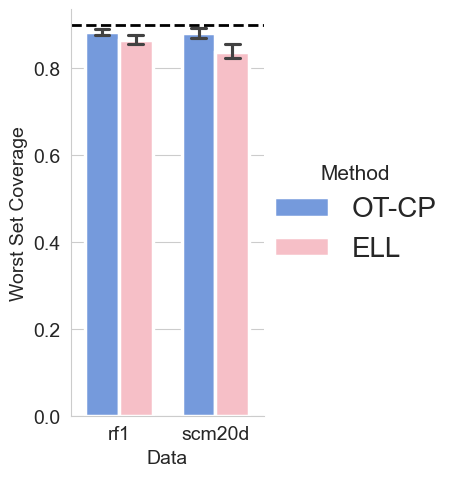

In [ ]:
#df_results_coverage = pd.read_csv('reg_manypoints_realdata_WorstCoverages.csv') 
#df_results_coverage = pd.DataFrame(np.array(df_results_coverage),columns=["Worst Set Coverage","Method","Data"]) 
#df_results_coverage['Method'] = df_results_coverage['Method'].apply(lambda x: "OT-CP" if x =="MK" else "ELL")

plt.figure()
sns.set_style("whitegrid")
g =sns.catplot( 
        data=df_results_coverage,  kind="bar",
        x="Data", y="Worst Set Coverage", hue="Method", palette=["cornflowerblue","lightpink"],height=5,width=0.7,capsize=0.3,aspect=0.6,linewidth=2.5,legend=["OT-CP","ELL"]
)   
g.refline(y=alpha, color='black',linestyle="dashed",linewidth=2)
sns.move_legend(g, loc="center right",fontsize='20',bbox_to_anchor=(1.1,.55),title_fontsize='15')
#plt.savefig("Realmanypoints_RegressionConditionalCoverage.pdf", format="pdf",bbox_inches="tight") 